In [1]:
import os
import sys
import numpy as np
import librosa
from math import ceil
import torch
from torch import nn, optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from fractions import Fraction
from torch.utils.data import DataLoader, TensorDataset
import pickle
from time import time
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import random
from math import ceil
from scipy.signal import find_peaks, windows, convolve
from scipy.ndimage import gaussian_filter  

DIC={
    0:[0, 0, 0, 0], 1:[0, 0, 0, 1], 2:[0, 0, 1, 0], 3:[0, 0, 1, 1],
    4:[0, 1, 0, 0], 5:[0, 1, 0, 1], 6:[0, 1, 1, 0], 7:[0, 1, 1, 1],
    8:[1, 0, 0, 0], 9:[1, 0, 0, 1], 10:[1, 0, 1, 0], 11:[1, 0, 1, 1],
    12:[1, 1, 0, 0], 13:[1, 1, 0, 1], 14:[1, 1, 1, 0], 15:[1, 1, 1, 1]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def split_music(data,seq_len):
    res=[]
    data_=np.pad(data,((0,0),(0,0),(seq_len,seq_len),(0,0)))
    for i in range(data.shape[2]):
        temp=data_[:,:,i:i+2*seq_len+1,:]
        res.append(temp)
    return np.array(res)

def pad_data(music,label):
    '''输入两个对应的列表'''
    res_m=[]
    res_l=[]
    pad_len=0
    for i in music:
        if pad_len<i.shape[1]:
            pad_len=i.shape[1]
    for i,j in zip(music,label):
        res_m.append(np.pad(i,((0,0),(0,pad_len-i.shape[1]),(0,0))))
        res_l.append(np.pad(j,(0,pad_len-j.shape[0])))
    return np.array(res_m),np.array(res_l)

def get_f1(y_true,y_pred,y):
    '''
        y_true:array   shape:1D
        y_pred:tensor  shape:1D
    '''
    peaks=get_peak(torch.sigmoid(y_pred).detach().cpu().numpy(),y)
    pred_arr1=np.zeros(y_true.shape)
    pred_arr2=np.zeros(y_true.shape)
    pred_arr1[peaks]=1
    for i in range(5):
        pred_arr2[peaks+(3-i)]=1

    # 真正例（True Positives, TP）
    tp = np.sum((y_true >= 1) & (pred_arr2 == 1))
    # 假正例（False Positives, FP）
    fp = np.sum((y_true == 0) & (pred_arr1== 1))
    # 假负例（False Negatives, FN）
    fn = np.sum((y_true >= 1) & (pred_arr2 == 0))

    # 精确度
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # 召回率
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # F1分数
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision,recall,f1

def get_input_data(music_data,label_data,seq_len):
    res_m=[]
    res_l=[]
    music_data=np.pad(music_data,((0,0),(seq_len,seq_len),(0,0)))
    for i in range(seq_len,music_data.shape[1]-seq_len):
        res_m.append(music_data[:,i-seq_len:i+seq_len+1,:])
        res_l.append(label_data[i-seq_len])
    return np.array(res_m),np.array(res_l)

def get_peak(data,y):
    window = windows.hamming(3)
    smoothed_pred = convolve(data, window / window.sum(), mode='same')
    peaks,_=find_peaks(smoothed_pred, height=y*data.mean(),distance=3,prominence=0)
    return peaks

def Normalization(datas):
    Min = np.min(datas)
    Max = np.max(datas)
    return (datas-Min)/(Max-Min)

In [3]:
with open(f'train data/music_data1.pkl', 'rb') as file:
    music_data = pickle.load(file)
with open(f'train data/labels_data1.pkl', 'rb') as file:
    labels_data = pickle.load(file)

# with open(f'train data/valid_music_data.pkl', 'rb') as file:
#     valid_music = pickle.load(file)
# with open(f'train data/valid_labels_data.pkl', 'rb') as file:
#     valid_label = pickle.load(file)
    
# with open(f'train data/test_music_data.pkl', 'rb') as file:
#     test_music = pickle.load(file)
# with open(f'train data/test_labels_data.pkl', 'rb') as file:
#     test_label = pickle.load(file) 

In [4]:
class T(nn.Module):
    def __init__(self):
        global DIC,MEL_DIM,HIDDEN_DIM
        super(T, self).__init__()
        self.relu=nn.ReLU()
        
        self.conv=nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(7,3))
        self.pool=nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.conv1=nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        self.lstm = nn.LSTM(7*8*20,200, num_layers=2,dropout=0,bidirectional=True,batch_first=True)
        self.fc0=nn.Linear(400,258)
        self.fc1=nn.Linear(258,128)
        self.fc2=nn.Linear(128,1)
        
    def forward(self,Input,hidden=None):
        batch_size,seq_size,channels,seq_len,mel_dim=Input.shape#batch_size,seq_size,channels,seq_len,mel_dim -> n1,n2,3,15,80
        conv_out=self.pool(self.relu(self.conv(Input.reshape(batch_size*seq_size,channels,seq_len,mel_dim))))
        conv_out=self.pool1(self.relu(self.conv1(conv_out)))
        conv_out=conv_out.reshape(batch_size,seq_size,7*8*20)
        lstmout,hidden=self.lstm(conv_out,hidden)
        out=self.relu(self.fc0(lstmout))
        out=self.relu(self.fc1(out))
        out=self.fc2(out)
        hidden=(hidden[0].detach(),hidden[1].detach())
        return out.flatten(),hidden

In [5]:
MT=T().to(device)
optimizer = optim.SGD(MT.parameters(),lr=0.1)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()

In [9]:
# checkpoint = torch.load('./model/CBiLSTM/T/200.pth')
# MT.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [6]:
#填充数据
music_data,labels_data_=pad_data(music_data,labels_data)

#用于可视化
plot_music=music_data[0]
plot_label=labels_data[0]

#应用高斯模糊
labels_data=Normalization(gaussian_filter(np.array(labels_data_>0,dtype=float),sigma=0.5))

In [7]:
losses=[]
F1s=[]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

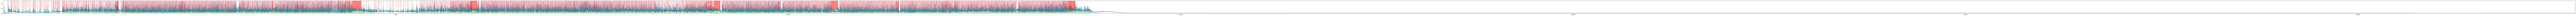

0.21556908464663138 0.6575921253227401


In [15]:
batch_size=10
seq_len=7
seq_batch=2048
Cal_F1=True


for epoch in tqdm(range(1)):
    if (epoch+1)%10==0:
        torch.save({'model_state_dict': MT.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                }, f'model/CBiLSTM/T/{epoch+1}.pth')
    loss_temp=[]
    hidden=None
    OUTPLOT=[]#用于可视化
    p_temp=[]#precision temporary list
    r_temp=[]#recall temporary list
    for i in tqdm(range(music_data.shape[0]//batch_size)):#分批次训练
        inputs=[]
        labels=[]
        PREDLABELS=None#用于计算F1
        for j in range(batch_size):#分批次处理填充后的数据
            input_,label_=get_input_data(music_data[i*10+j],labels_data[i*10+j],seq_len=7)
            inputs.append(input_)
            labels.append(label_)
        inputs=np.array(inputs)
        labels=np.array(labels)
        for k in range(music_data.shape[2]//seq_batch):#批次间截取长度
            Input=inputs[:,k*seq_batch:(k+1)*seq_batch,:,:,:]
            label=labels[:,k*seq_batch:(k+1)*seq_batch]
            Input=torch.tensor(Input).to(device)
            label=torch.tensor(label).float().to(device)
            output,hidden=MT(Input,hidden)
            loss=criterion(output.flatten(),label.flatten())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_temp.append(loss.item())
            if PREDLABELS==None:
                PREDLABELS=output.reshape(-1,seq_batch)
            else:
                PREDLABELS=torch.cat((PREDLABELS,output.reshape(-1,seq_batch)),dim=1)
            if i==0:
                OUTPLOT+=output[:seq_batch].detach().tolist()
        label_temp=labels_data_[i*batch_size:(i+1*batch_size),:]
        
        #计算precision,recall
        if Cal_F1 is True:
            for l in range(label_temp.shape[0]):
                precision,recall,_=get_f1(label_temp[l],PREDLABELS[l],1.6)
                p_temp.append(precision)
                r_temp.append(recall)
    if Cal_F1 is True:
        p=sum(p_temp)/len(p_temp)
        r=sum(r_temp)/len(r_temp)
        F1=2 * (p * r) / (p + r) if (p + r) > 0 else 0
        F1s.append(F1)

    #可视化
    OUTPLOT=torch.sigmoid(torch.tensor(OUTPLOT)).numpy()
    peaks=get_peak(OUTPLOT,2)
    plt.figure(figsize=(400,2))
    plt.plot(OUTPLOT)
    for x,y in enumerate(plot_label):
        if y>=1:
            plt.axvline(x=x, color='red', linestyle='-', linewidth=1,ymin=0.3, ymax=1)
    for x in peaks:
        plt.axvline(x=x, color='green', linestyle='-', linewidth=1,ymin=0, ymax=0.3)
    plt.xlim(0,OUTPLOT.shape[0])
    plt.ylim(0, max(OUTPLOT))
    plt.show()


    losses.append(sum(loss_temp)/len(loss_temp))
    print(losses[-1],F1)
            

Text(32, 0.6845099502134374, 'max(1.6,0.6845099502134374)')

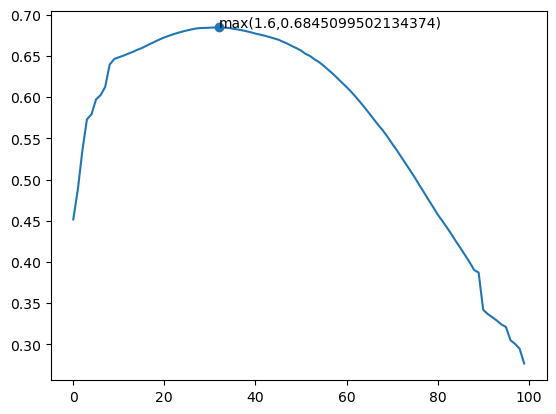

In [51]:
#阈值对F1的影响

f1_temp=[]
label_temp=labels_data_[70:80,:]
for n in range(100):
    p_temp=[]
    r_temp=[]
    for l in range(label_temp.shape[0]):
        precision,recall,_=get_f1(label_temp[l],PREDLABELS[l],n*0.05)
        p_temp.append(precision)
        r_temp.append(recall)
    p=sum(p_temp)/len(p_temp)
    r=sum(r_temp)/len(r_temp)
    f1_temp.append(2 * (p * r) / (p + r) if (p + r) > 0 else 0)
plt.plot(f1_temp)
plt.scatter(f1_temp.index(max(f1_temp)),max(f1_temp))
plt.text(f1_temp.index(max(f1_temp)),max(f1_temp),f'max({f1_temp.index(max(f1_temp))*0.05},{max(f1_temp)})')

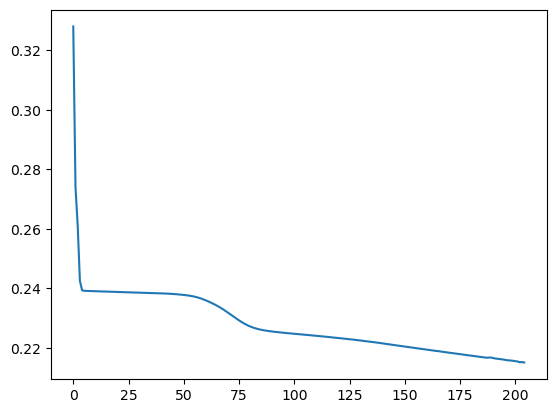

In [26]:
plt.plot(losses)